#Lokaskýrsla í vélrænu námi
###  Magnús Páll og Viktor Ingi

Hér er kóði sem vinnur með tvö gagnasett.

Setur_PT100 og Setur_RH.

Gagnasett koma frá sitthvorri tegund veðurmæla.

Skoðum fyrst Setur_PT100 þar sem það er mun hreinna gagnasett ásamt því að hafa svokallað „worst case scenario“ sem reynist erfitt fyrir flestar aðgerðir machine learning að flokka sem outliers.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Load-a dataset
df = pd.read_excel('Setur_PT100.xlsx',skiprows=16)
#Breyta , í . svo python reiknar eitthvað og breytir missing values í NaN.
df['Value [°C]'] = pd.to_numeric(df['Value [°C]'].astype(str).str.replace(',', '.'), errors='coerce')

In [ ]:
# Skoðum hversu mörg missing values eru
df.isnull().sum()

Time stamp         0
Value [°C]        28
State of value     0
dtype: int64

<Figure size 1500x600 with 0 Axes>

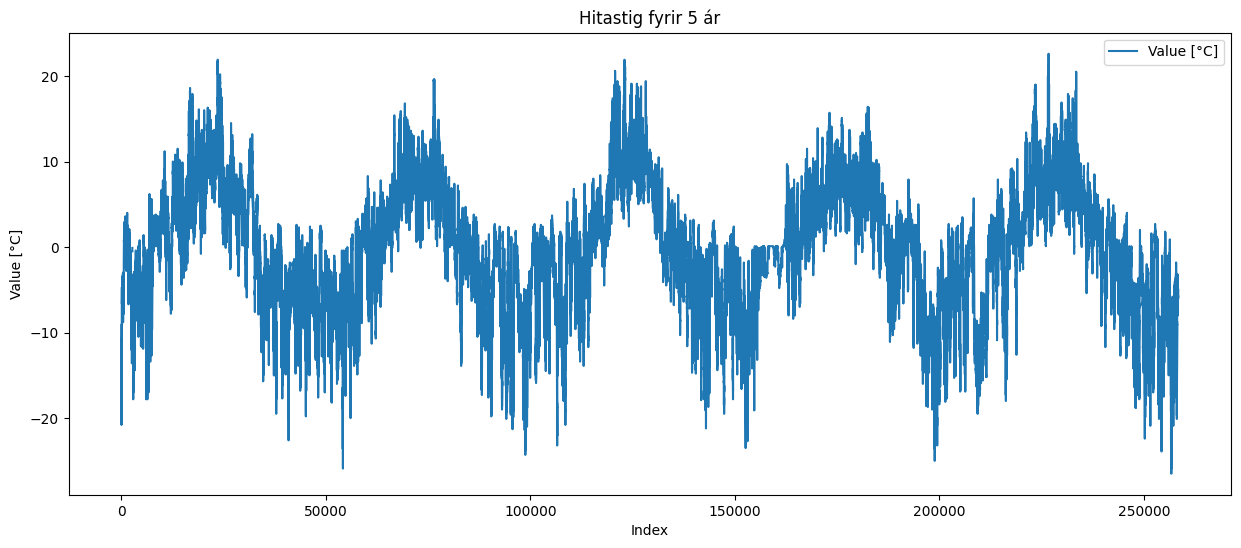

In [ ]:
# Plota allt gagnasettið
plt.figure(figsize=(15, 6))

# Plottið
plot_cols = ['Value [°C]']
plot_features = df[plot_cols]
plot_features.plot(subplots=True, figsize=(15, 6))
plt.title('Hitastig fyrir 5 ár')
plt.ylabel('Value [°C]')
plt.xlabel('Index')

plt.show()

Hér kemur svokallaða "worst case scenario".

Í þessu tilfelli er veðurstöðin greinilega tekin úr sambandi og dettur út í rúman klukkutíma áður en henni er komið aftur í gang en þá skapast þrír útlægir toppar þar sem skynjari er greinilega að stilla sig af.

               Time stamp  Value [°C]       State of value
2680  06.03.2019 14:40:00        -7.2      200 (Unchecked)
2681  06.03.2019 14:50:00        -7.2      200 (Unchecked)
2682  06.03.2019 15:00:00        -6.6      200 (Unchecked)
2683  06.03.2019 15:10:00        -5.2      200 (Unchecked)
2684  06.03.2019 15:20:00        -6.8      200 (Unchecked)
2685  06.03.2019 16:30:00         NaN          missing (M)
2686  06.03.2019 16:40:00        -0.1  200 (Unchecked), VF
2687  06.03.2019 16:50:00        -0.5      200 (Unchecked)
2688  06.03.2019 17:00:00        -0.5      200 (Unchecked)
2689  06.03.2019 17:20:00         NaN          missing (M)
2690  06.03.2019 17:30:00        -7.7  200 (Unchecked), VF
2691  06.03.2019 17:40:00        -7.9      200 (Unchecked)
2692  06.03.2019 17:50:00        -7.7      200 (Unchecked)
2693  06.03.2019 18:00:00        -7.5      200 (Unchecked)
2694  06.03.2019 18:10:00        -7.6      200 (Unchecked)
2695  06.03.2019 18:20:00        -7.8      200 (Unchecke

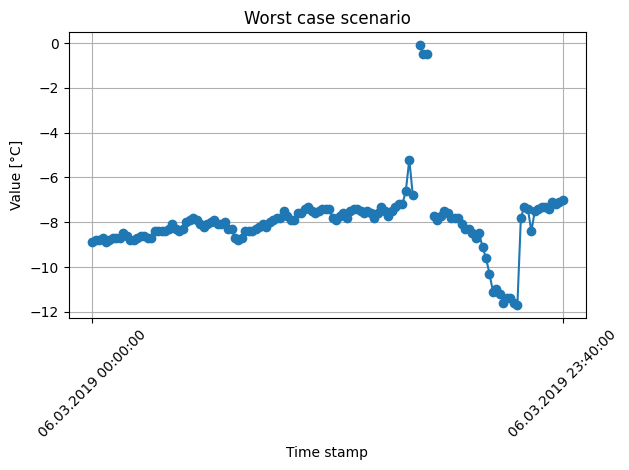

In [ ]:
# Worst case scenario dæmi þar sem er missing values og outliers
print(df.iloc[2680:2696])

# Plota þau gildi
valid_data = df

valid_t = valid_data['Time stamp'][2592:2728]
valid_C = valid_data['Value [°C]'][2592:2728]

# Plot
plt.plot(valid_t, valid_C, marker='o')
plt.xlabel('Time stamp')
plt.ylabel('Value [°C]')
plt.title('Worst case scenario')
plt.xticks([valid_t.iloc[0], valid_t.iloc[-1]], rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Skoðum svo tíðnirit fyrir Setur_PT100.

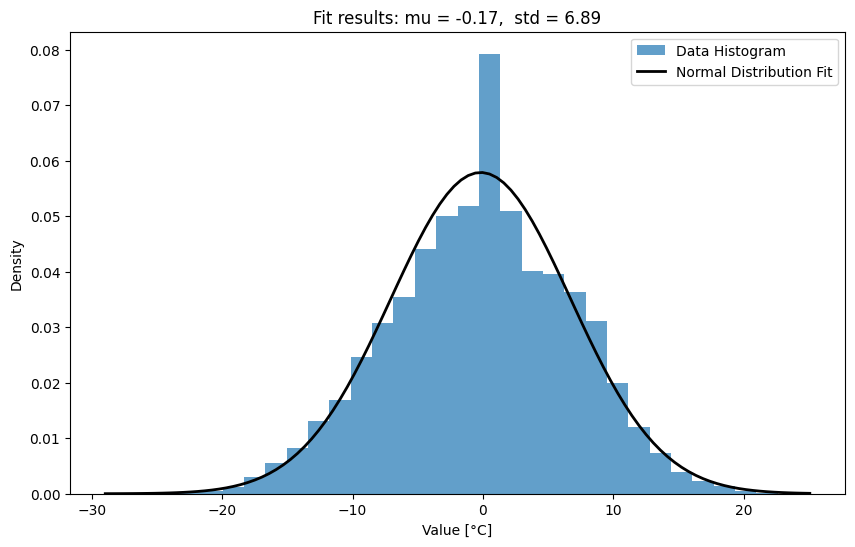

In [ ]:
from scipy.stats import norm

# mean og std af hitastigi
mean = df['Value [°C]'].mean()
std = df['Value [°C]'].std()

# figure stærð
plt.figure(figsize=(10, 6))

# Plot histogram af hitastigi
hist_data = plt.hist(df['Value [°C]'], bins=30, alpha=0.7, density=True, label='Data Histogram')

# punkta x-ás fyrir normal fall
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# Búa til normal gauss dreifingu
p = norm.pdf(x, mean, std)

# plota normal gauss dreifingu yfir histogram
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution Fit')

title = "Fit results: mu = %.2f,  std = %.2f" % (mean, std)
plt.title(title)
plt.xlabel('Value [°C]')
plt.ylabel('Density')
plt.legend()

plt.show()

Í kóða hér að neðan tökum við gagnasafnið Setur_PT100 og byrjum á því að normalize-a gögnin með StandardScaler og notum svokallað „moving median“ til að finna út hvaða hitastig eru outliers í gagnasettinu.

Upprunalega reyndum við að nota línulega aðhvarfsgreiningu en voru þær niðurstöður ekki nægilega góðar og aðferðin með bestu niðurstöður var SVR-aðferðin sem má sjá í viðauka neðst í skjalinu.

Ítrum okkur í gegnum hvern glugga og ákveðum að threshold fyrir mörkin á outliers er $mean + 4 * std$ þ.e. virkilega litlar líkur á að outliers sé. Merkjum svo einnig alla outliers sem $True$ í sérdálki.

Endum því með u.þ.b. 2500 hitastig sem merkjast sem outliers.

Héðan í frá sýnum við eingöngu fyrstu 50 þúsund stökin eða sirka árið 2019 þar sem mesta skekkja er í því.

Hæsta hitastig:  22.6
Lægsta hitastig:  -26.5


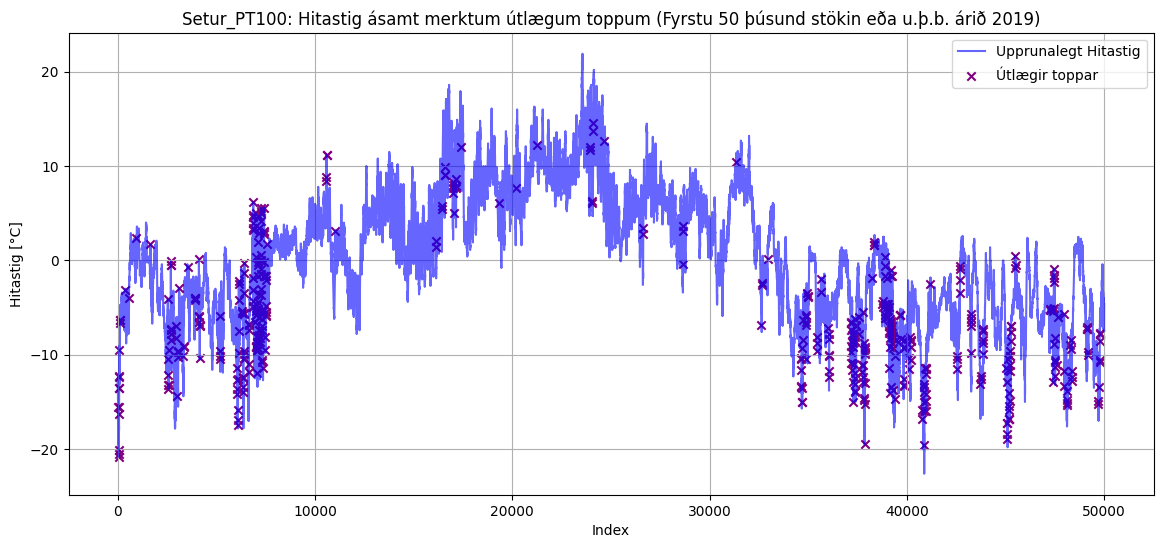

Custom Group Anomalies detected:
                 Time stamp  Value [°C]  Custom Group Anomaly
32      16.02.2019 05:20:00       -15.5                  True
37      16.02.2019 06:10:00       -20.1                  True
39      16.02.2019 06:30:00       -20.5                  True
40      16.02.2019 06:40:00       -20.8                  True
42      16.02.2019 07:00:00       -16.3                  True
...                     ...         ...                   ...
258087  14.02.2024 05:50:00       -20.1                  True
258127  14.02.2024 12:30:00       -12.4                  True
258140  14.02.2024 14:40:00        -9.5                  True
258141  14.02.2024 14:50:00        -9.6                  True
258142  14.02.2024 15:00:00        -9.3                  True

[2567 rows x 3 columns]


In [ ]:
from sklearn.preprocessing import StandardScaler

# Drop-a öllum missing values. aka '---'.
df.dropna(subset=['Value [°C]'], inplace=True)

# Finn hæsta og lægsta hitastig gagnasafnsins.
print('Hæsta hitastig: ',df['Value [°C]'].max())
print('Lægsta hitastig: ', df['Value [°C]'].min())

# skala gögninn.
scaler = StandardScaler()
df['Normalized T (degC)'] = scaler.fit_transform(df[['Value [°C]']])

# Reikna moving median og frávik til að skynja outliers.
window_size = 9
df['Moving Median'] = df['Normalized T (degC)'].rolling(window=window_size, min_periods=1).median()
df['Deviation from Median'] = np.abs(df['Normalized T (degC)'] - df['Moving Median'])

# Tökum meðaltal og staðalfrávik af fráviki af median
mean_deviation = df['Deviation from Median'].mean()
std_deviation = df['Deviation from Median'].std()

# Set threshold sem meðaltal plús 4 sinnum staðalfrávik.
deviation_threshold = mean_deviation + 4 * std_deviation

df['Custom Group Anomaly'] = df['Deviation from Median'] > deviation_threshold

# Plot af upprunalegu gögnum ásamt merktu outliers
plt.figure(figsize=(14, 6))
plt.plot(df.index[:50000], df['Value [°C]'][:50000], label='Upprunalegt Hitastig', color='blue', alpha=0.6)
plt.scatter(df.index[df['Custom Group Anomaly'] & (df.index < 50000)], df['Value [°C]'][df['Custom Group Anomaly'] & (df.index < 50000)], c='purple', label='Útlægir toppar', marker='x')
#plt.scatter(df.index[df['Custom Group Anomaly']], df['Normalized T (degC)'][df['Custom Group Anomaly']], c='red', label='Custom Group Anomalies', marker='x')
plt.xlabel('Index')
plt.ylabel('Hitastig [°C]')
plt.title('Setur_PT100: Hitastig ásamt merktum útlægum toppum (Fyrstu 50 þúsund stökin eða u.þ.b. árið 2019)')
plt.legend()
plt.grid(True)
plt.show()

# Prentum outliers
print("Custom Group Anomalies detected:")
print(df[df['Custom Group Anomaly'] == True][['Time stamp', 'Value [°C]', 'Custom Group Anomaly']])


Skoðum hvort moving median nái að skrá „worst case scenario“ sem outliers. (Hvort Custom group anomaly dálkurinn sé True við -0.1 og -0.5 °C).

Sjáum því að outliers með index 2686, 2687 og 2688 eru merktir sem True.

In [ ]:
print(df.iloc[2680:2696])

               Time stamp  Value [°C]       State of value  \
2680  06.03.2019 14:40:00        -7.2      200 (Unchecked)   
2681  06.03.2019 14:50:00        -7.2      200 (Unchecked)   
2682  06.03.2019 15:00:00        -6.6      200 (Unchecked)   
2683  06.03.2019 15:10:00        -5.2      200 (Unchecked)   
2684  06.03.2019 15:20:00        -6.8      200 (Unchecked)   
2686  06.03.2019 16:40:00        -0.1  200 (Unchecked), VF   
2687  06.03.2019 16:50:00        -0.5      200 (Unchecked)   
2688  06.03.2019 17:00:00        -0.5      200 (Unchecked)   
2690  06.03.2019 17:30:00        -7.7  200 (Unchecked), VF   
2691  06.03.2019 17:40:00        -7.9      200 (Unchecked)   
2692  06.03.2019 17:50:00        -7.7      200 (Unchecked)   
2693  06.03.2019 18:00:00        -7.5      200 (Unchecked)   
2694  06.03.2019 18:10:00        -7.6      200 (Unchecked)   
2695  06.03.2019 18:20:00        -7.8      200 (Unchecked)   
2696  06.03.2019 18:30:00        -7.8      200 (Unchecked)   
2697  06

Hér viljum við taka þau gildi sem eru outliers og skipta þeim út fyrir meðaltal gildi af nágrönnum með því skilyrði að nota ekki gildi einnig merkt sem outliers í nágrannaútreikninga.

        Value [°C]  Imputed Value [°C]  Custom Group Anomaly
0            -13.4               -13.4                 False
1            -12.4               -12.4                 False
2            -12.4               -12.4                 False
3            -13.1               -13.1                 False
4            -14.1               -14.1                 False
...            ...                 ...                   ...
258381        -6.0                -6.0                 False
258382        -6.0                -6.0                 False
258383        -5.9                -5.9                 False
258384        -5.8                -5.8                 False
258385        -5.8                -5.8                 False

[258386 rows x 3 columns]


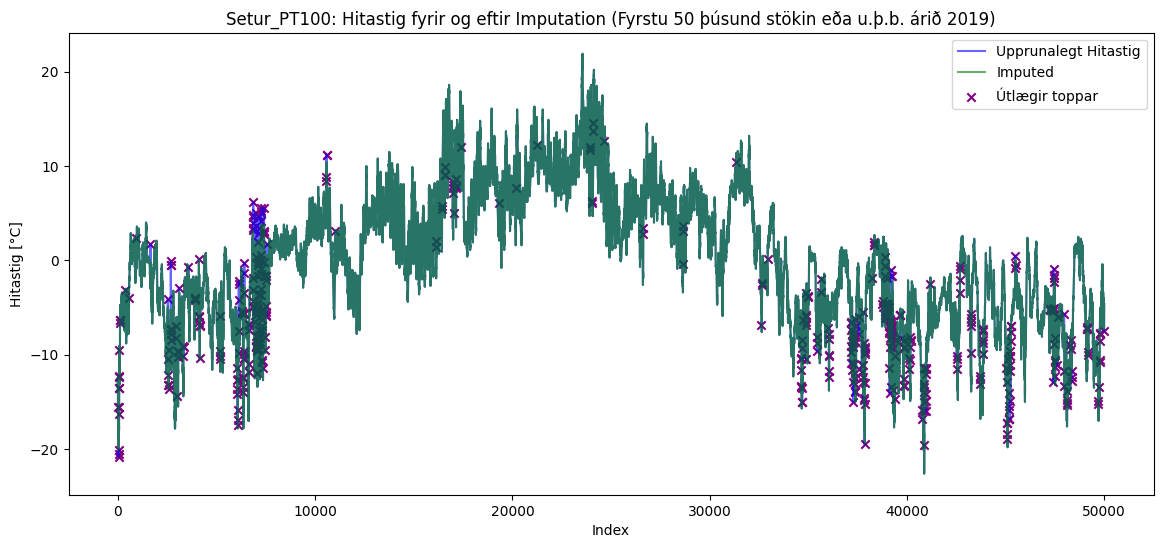

In [ ]:

# Sér hannað fall sem reiknar meðaltal af nágrönnum til að skipta út
# outliers fyrir trúanleg gildi. Fall tryggir að outliers séu ekki notaðir
# í útreiking.
def impute_with_neighbors(df, value_column, flag_column, max_neighbors=5):
    # Svo það kemur ekki index error
    df.reset_index(drop=True, inplace=True)

    # Búum til afrit af hitastigi
    modified_values = df[value_column].copy()

    # ítrar í gegnum gagnasett
    for i in df.index:
        # Athugar hvort núverandi gildi sé outlier
        if df.loc[i, flag_column]:
            neighbors = []

            # Leitar af non-outlier nágrönnum innan gefins sviðs.
            for offset in range(1, max_neighbors + 1):

                # Athugar nágranna fyrir framan
                if i + offset < len(df) and not df.loc[i + offset, flag_column]:
                    neighbors.append(df.loc[i + offset, value_column])

                # Athugar nágranna fyrir aftan
                if i - offset >= 0 and not df.loc[i - offset, flag_column]:
                    neighbors.append(df.loc[i - offset, value_column])

                # Brýtur út ef nóg af nágrönnum er fundið
                if len(neighbors) >= max_neighbors:
                    break

            # Reiknar núverandi gildi út frá meðaltali nágranna og setur í gagnasett.
            if neighbors:
                modified_values[i] = np.mean(neighbors)

    return modified_values

# Búa til nýjan dálk og kalla á fall til að fá ný gildi.
df['Imputed Value [°C]'] = impute_with_neighbors(df, 'Value [°C]', 'Custom Group Anomaly')

# Prenta nýju gildi ásamt gömlu og outliers falli
print(df[['Value [°C]', 'Imputed Value [°C]', 'Custom Group Anomaly']])

# Plota gömlu gildi á móti nýju
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df.index[:50000], df['Value [°C]'][:50000], label='Upprunalegt Hitastig', color='blue', alpha=0.6)
plt.plot(df.index[:50000], df['Imputed Value [°C]'][:50000], label='Imputed', color='green', alpha=0.6)
plt.scatter(df.index[df['Custom Group Anomaly'] & (df.index < 50000)], df['Value [°C]'][df['Custom Group Anomaly'] & (df.index < 50000)], c='purple', label='Útlægir toppar', marker='x')
#plt.scatter(df.index[df['Custom Group Anomaly']], df['Normalized T (degC)'][df['Custom Group Anomaly']], c='red', label='Custom Group Anomalies', marker='x')
plt.xlabel('Index')
plt.ylabel('Hitastig [°C]')
plt.title('Setur_PT100: Hitastig fyrir og eftir Imputation (Fyrstu 50 þúsund stökin eða u.þ.b. árið 2019)')
plt.legend()
plt.show()



Athugum aftur „worst case scenario“ og sjáum að „Imputed value“ fyllir outliers af góðu gildi miðað við nágranna.

In [ ]:
print(df.iloc[2680:2696])

               Time stamp  Value [°C]       State of value  \
2680  06.03.2019 14:40:00        -7.2      200 (Unchecked)   
2681  06.03.2019 14:50:00        -7.2      200 (Unchecked)   
2682  06.03.2019 15:00:00        -6.6      200 (Unchecked)   
2683  06.03.2019 15:10:00        -5.2      200 (Unchecked)   
2684  06.03.2019 15:20:00        -6.8      200 (Unchecked)   
2685  06.03.2019 16:40:00        -0.1  200 (Unchecked), VF   
2686  06.03.2019 16:50:00        -0.5      200 (Unchecked)   
2687  06.03.2019 17:00:00        -0.5      200 (Unchecked)   
2688  06.03.2019 17:30:00        -7.7  200 (Unchecked), VF   
2689  06.03.2019 17:40:00        -7.9      200 (Unchecked)   
2690  06.03.2019 17:50:00        -7.7      200 (Unchecked)   
2691  06.03.2019 18:00:00        -7.5      200 (Unchecked)   
2692  06.03.2019 18:10:00        -7.6      200 (Unchecked)   
2693  06.03.2019 18:20:00        -7.8      200 (Unchecked)   
2694  06.03.2019 18:30:00        -7.8      200 (Unchecked)   
2695  06

Tíðni rit með Imputed gögnum frekar en upprunalegu gögnum.

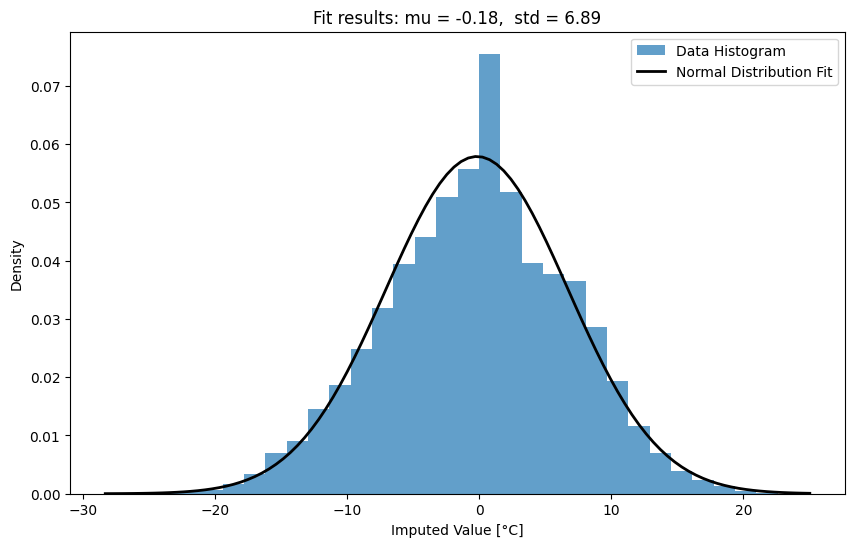

In [ ]:
from scipy.stats import norm

# mean og std af hitastigi
mean = df['Imputed Value [°C]'].mean()
std = df['Imputed Value [°C]'].std()

# figure stærð
plt.figure(figsize=(10, 6))

# Plot histogram af hitastigi
hist_data = plt.hist(df['Imputed Value [°C]'], bins=30, alpha=0.7, density=True, label='Data Histogram')

# punkta x-ás fyrir normal fall
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# Búa til normal gauss dreifingu
p = norm.pdf(x, mean, std)

# plota normal gauss dreifingu yfir histogram
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution Fit')

title = "Fit results: mu = %.2f,  std = %.2f" % (mean, std)
plt.title(title)
plt.xlabel('Imputed Value [°C]')
plt.ylabel('Density')
plt.legend()

plt.show()

Nú þegar aðferðin virkar á „worst case scenario“ þá getum við beitt sömu útreikningum á Setur_RH sem hefur meiri outliers en PT100 gagnasettið.

In [ ]:
import numpy as np
import pandas as pd
# Hlaða inn Setur_RH
df = pd.read_excel('Setur_RH.xlsx', skiprows=16)
#Breyta , í . svo python reiknar eitthvað og breytir missing values í NaN.
df['Value [°C]'] = pd.to_numeric(df['Value [°C]'].astype(str).str.replace(',', '.'), errors='coerce')

Skoðum hversu mörg missing values eru í setti

In [ ]:
df.isnull().sum()

Time stamp         0
Value [°C]        30
State of value     0
dtype: int64

<Figure size 1500x600 with 0 Axes>

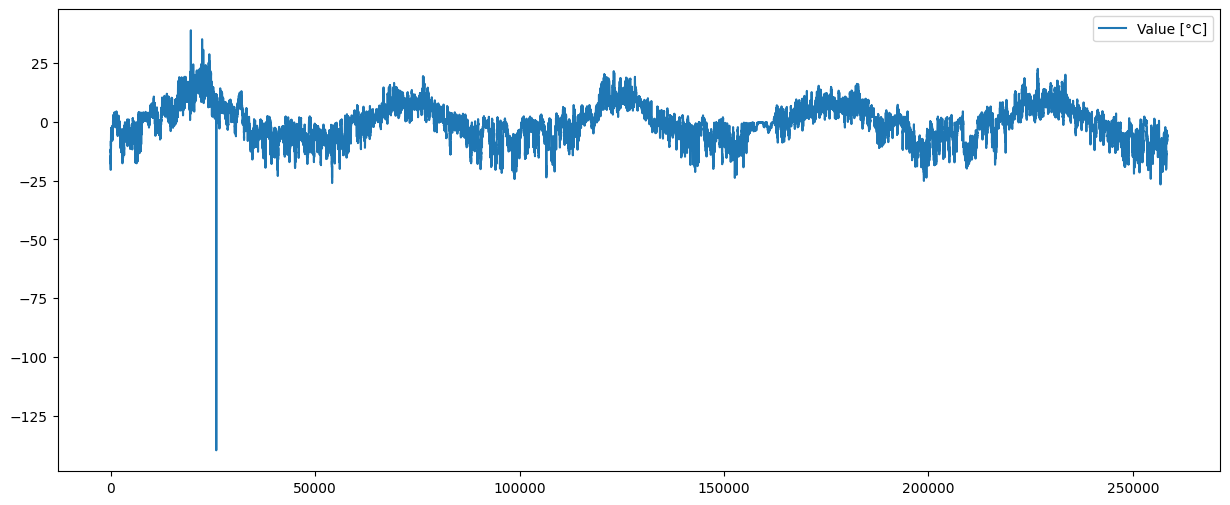

In [ ]:
# Plota allt gagnasettið
plt.figure(figsize=(15, 6))

# Plottið
plot_cols = ['Value [°C]']
plot_features = df[plot_cols]
plot_features.plot(subplots=True, figsize=(15, 6)) # Adjust figsize here as needed

plt.show()

Sjáum því augljóslega outlier í þessu gagnasetti.
Skoðum svo einnig tíðnirit.

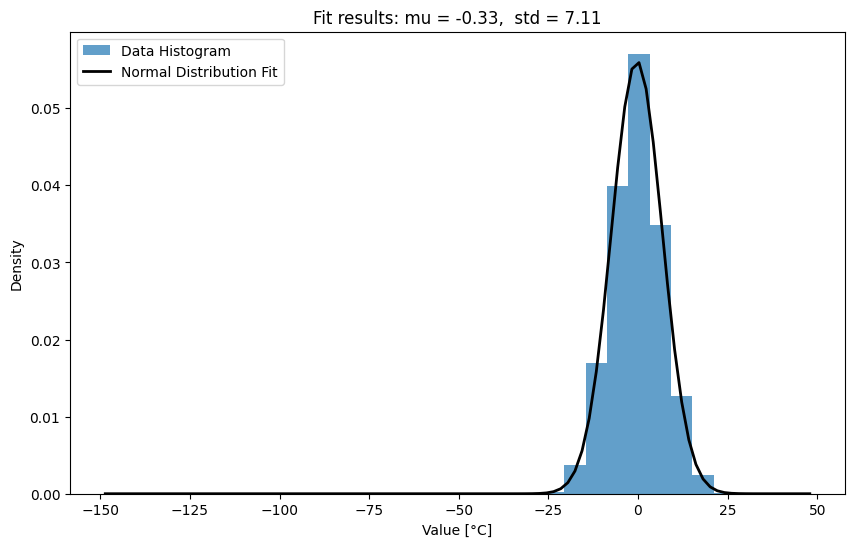

In [ ]:

from scipy.stats import norm

# mean og std af hitastigi
mean = df['Value [°C]'].mean()
std = df['Value [°C]'].std()

# figure stærð
plt.figure(figsize=(10, 6))

# Plot histogram af hitastigi
hist_data = plt.hist(df['Value [°C]'], bins=30, alpha=0.7, density=True, label='Data Histogram')

# punkta x-ás fyrir normal fall
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# Búa til normal gauss dreifingu
p = norm.pdf(x, mean, std)

# plota normal gauss dreifingu yfir histogram
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution Fit')

title = "Fit results: mu = %.2f,  std = %.2f" % (mean, std)
plt.title(title)
plt.xlabel('Value [°C]')
plt.ylabel('Density')
plt.legend()

plt.show()

Merkjum þá einnig útlægu toppa með moving median-aðferðinni.

U.þ.b. 1700 útlægir toppar eru í þessu gagnsetti samkvæmt aðferð.

Hæsta hitastig:  39.0
Lægsta hitastig:  -139.7


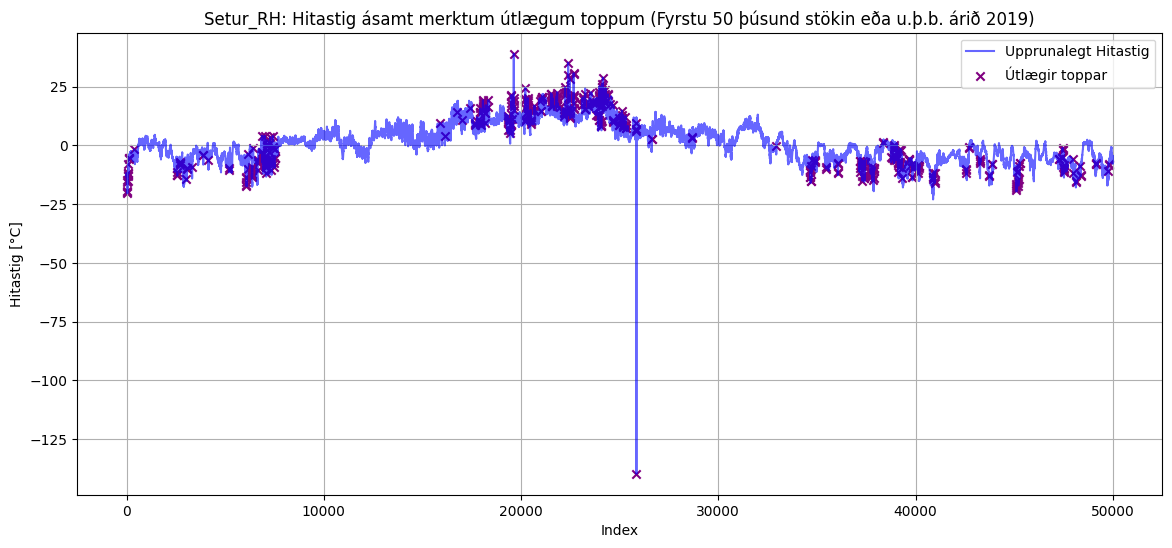

Custom Group Anomalies detected:
                 Time stamp  Value [°C]  Custom Group Anomaly
32      16.02.2019 05:20:00       -14.7                  True
37      16.02.2019 06:10:00       -19.4                  True
39      16.02.2019 06:30:00       -19.8                  True
40      16.02.2019 06:40:00       -20.4                  True
42      16.02.2019 07:00:00       -15.7                  True
...                     ...         ...                   ...
258093  14.02.2024 05:40:00       -18.5                  True
258094  14.02.2024 05:50:00       -20.2                  True
258134  14.02.2024 12:30:00       -12.3                  True
258147  14.02.2024 14:40:00        -9.9                  True
258148  14.02.2024 14:50:00        -9.9                  True

[1703 rows x 3 columns]


In [ ]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Drop-a öllum missing values. aka '---'.
df.dropna(subset=['Value [°C]'], inplace=True)

# Finn hæsta og lægsta hitastig gagnasafnsins.
print('Hæsta hitastig: ',df['Value [°C]'].max())
print('Lægsta hitastig: ', df['Value [°C]'].min())


# skala gögninn.
scaler = StandardScaler()
df['Normalized T (degC)'] = scaler.fit_transform(df[['Value [°C]']])

# Reikna moving median og frávik til að skynja outliers.
window_size = 9
df['Moving Median'] = df['Normalized T (degC)'].rolling(window=window_size, min_periods=1).median()
df['Deviation from Median'] = np.abs(df['Normalized T (degC)'] - df['Moving Median'])

# Tökum meðaltal og staðalfrávik af fráviki af median
mean_deviation = df['Deviation from Median'].mean()
std_deviation = df['Deviation from Median'].std()

# Set threshold sem meðaltal plús 4 sinnum staðalfrávik.
deviation_threshold = mean_deviation + 4 * std_deviation

df['Custom Group Anomaly'] = df['Deviation from Median'] > deviation_threshold


# Plot af upprunalegu gögnum ásamt merktu outliers
plt.figure(figsize=(14, 6))
plt.plot(df.index[:50000], df['Value [°C]'][:50000], label='Upprunalegt Hitastig', color='blue', alpha=0.6)
plt.scatter(df.index[df['Custom Group Anomaly'] & (df.index < 50000)], df['Value [°C]'][df['Custom Group Anomaly'] & (df.index < 50000)], c='purple', label='Útlægir toppar', marker='x')
#plt.scatter(df.index[df['Custom Group Anomaly']], df['Normalized T (degC)'][df['Custom Group Anomaly']], c='red', label='Custom Group Anomalies', marker='x')
plt.xlabel('Index')
plt.ylabel('Hitastig [°C]')
plt.title('Setur_RH: Hitastig ásamt merktum útlægum toppum (Fyrstu 50 þúsund stökin eða u.þ.b. árið 2019)')
plt.legend()
plt.grid(True)
plt.show()

# Prentum outliers
print("Custom Group Anomalies detected:")
print(df[df['Custom Group Anomaly'] == True][['Time stamp', 'Value [°C]', 'Custom Group Anomaly']])


Reiknum svo ný gildi á outliers.

        Value [°C]  Imputed Value [°C]  Custom Group Anomaly
0            -12.6               -12.6                 False
1            -11.7               -11.7                 False
2            -11.7               -11.7                 False
3            -12.3               -12.3                 False
4            -13.4               -13.4                 False
...            ...                 ...                   ...
258388        -6.3                -6.3                 False
258389        -6.1                -6.1                 False
258390        -6.1                -6.1                 False
258391        -6.1                -6.1                 False
258392        -5.9                -5.9                 False

[258393 rows x 3 columns]


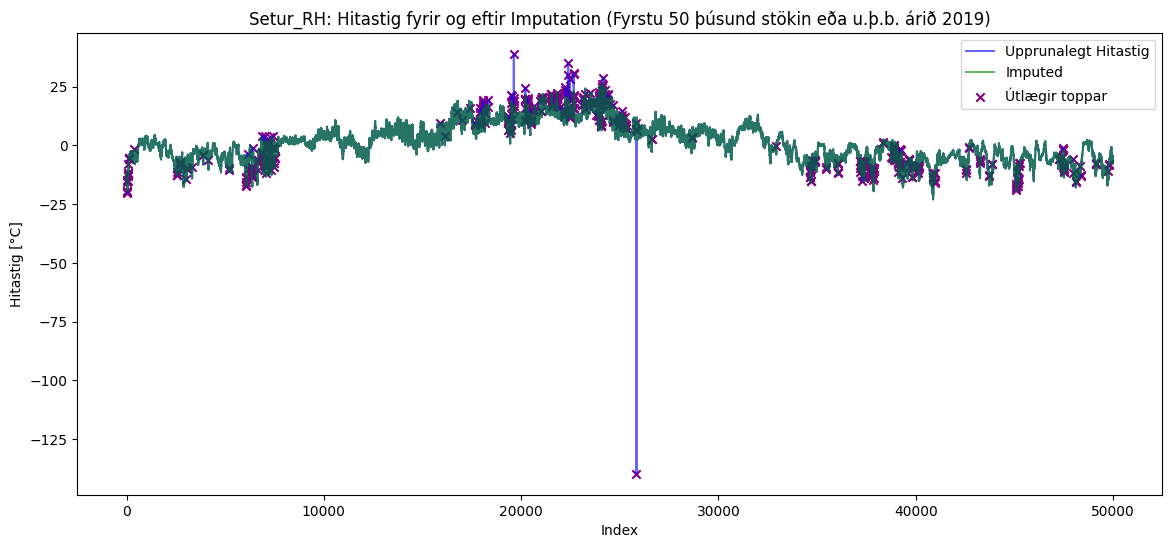

In [ ]:

# Sér hannað fall sem reiknar meðaltal af nágrönnum til að skipta út
# outliers fyrir trúanleg gildi. Fall tryggir að outliers séu ekki notaðir
# í útreiking.
def impute_with_neighbors(df, value_column, flag_column, max_neighbors=5):
    # Svo það kemur ekki index error
    df.reset_index(drop=True, inplace=True)

    # Búum til afrit af hitastigi
    modified_values = df[value_column].copy()

    # ítrar í gegnum gagnasett
    for i in df.index:
        # Athugar hvort núverandi gildi sé outlier
        if df.loc[i, flag_column]:
            neighbors = []

            # Leitar af non-outlier nágrönnum innan gefins sviðs.
            for offset in range(1, max_neighbors + 1):

                # Athugar nágranna fyrir framan
                if i + offset < len(df) and not df.loc[i + offset, flag_column]:
                    neighbors.append(df.loc[i + offset, value_column])

                # Athugar nágranna fyrir aftan
                if i - offset >= 0 and not df.loc[i - offset, flag_column]:
                    neighbors.append(df.loc[i - offset, value_column])

                # Brýtur út ef nóg af nágrönnum er fundið
                if len(neighbors) >= max_neighbors:
                    break

            # Reiknar núverandi gildi út frá meðaltali nágranna og setur í gagnasett.
            if neighbors:
                modified_values[i] = np.mean(neighbors)

    return modified_values

# Búa til nýjan dálk og kalla á fall til að fá ný gildi.
df['Imputed Value [°C]'] = impute_with_neighbors(df, 'Value [°C]', 'Custom Group Anomaly')

#Geymi þetta gagnasett sem df1 fyrir samanburð seinna
df1 = df

# Prenta nýju gildi ásamt gömlu og outliers falli
print(df[['Value [°C]', 'Imputed Value [°C]', 'Custom Group Anomaly']])

# Plota gömlu gildi á móti nýju
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df.index[:50000], df['Value [°C]'][:50000], label='Upprunalegt Hitastig', color='blue', alpha=0.6)
plt.plot(df.index[:50000], df['Imputed Value [°C]'][:50000], label='Imputed', color='green', alpha=0.6)
plt.scatter(df.index[df['Custom Group Anomaly'] & (df.index < 50000)], df['Value [°C]'][df['Custom Group Anomaly'] & (df.index < 50000)], c='purple', label='Útlægir toppar', marker='x')
#plt.scatter(df.index[df['Custom Group Anomaly']], df['Normalized T (degC)'][df['Custom Group Anomaly']], c='red', label='Custom Group Anomalies', marker='x')
plt.xlabel('Index')
plt.ylabel('Hitastig [°C]')
plt.title('Setur_RH: Hitastig fyrir og eftir Imputation (Fyrstu 50 þúsund stökin eða u.þ.b. árið 2019)')
plt.legend()
plt.show()


Skoðum betur hvað er að gerast í kringum útlægu toppa.

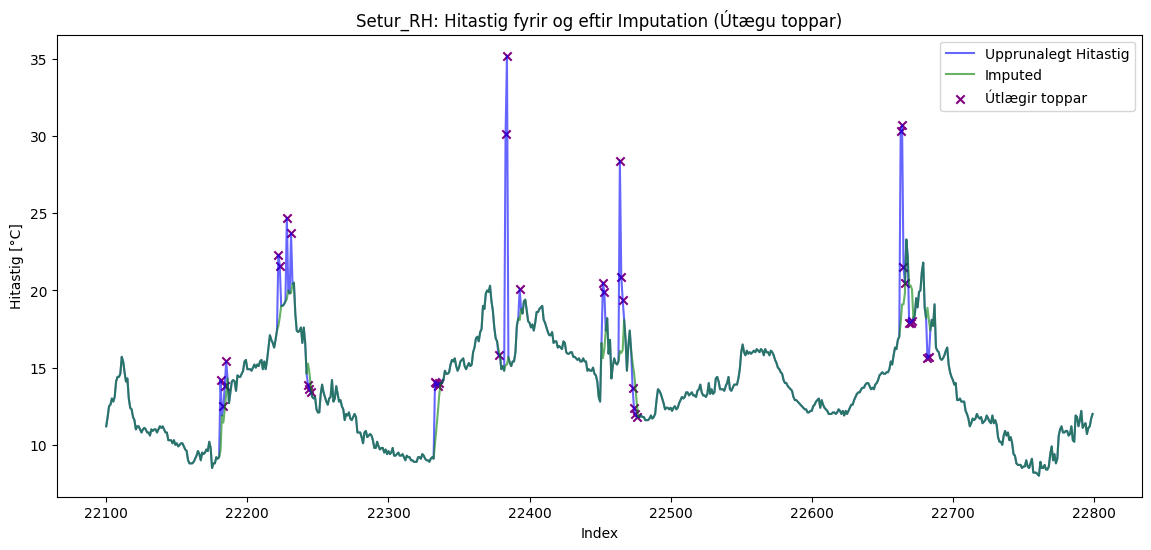

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df.index[22100:22800], df['Value [°C]'][22100:22800], label='Upprunalegt Hitastig', color='blue', alpha=0.6)
plt.plot(df.index[22100:22800], df['Imputed Value [°C]'][22100:22800], label='Imputed', color='green', alpha=0.6)

anomaly_mask = (df.index >= 22100) & (df.index < 22800) & df['Custom Group Anomaly']
plt.scatter(df.index[anomaly_mask], df['Value [°C]'][anomaly_mask], c='purple', label='Útlægir toppar', marker='x')

plt.xlabel('Index')
plt.ylabel('Hitastig [°C]')
plt.title('Setur_RH: Hitastig fyrir og eftir Imputation (Útægu toppar)')
plt.legend()
plt.show()

Gagnasett í kringum stærsta útlæga toppinn.

In [ ]:
print(df.iloc[df['Value [°C]'].idxmin() - 6:df['Value [°C]'].idxmin()+ 6])

                Time stamp  Value [°C]       State of value  \
25839  14.08.2019 19:00:00        10.8  200 (Unchecked), VF   
25840  14.08.2019 19:10:00        10.1      200 (Unchecked)   
25841  14.08.2019 19:20:00        10.1      200 (Unchecked)   
25842  14.08.2019 19:30:00         9.5      200 (Unchecked)   
25843  14.08.2019 19:40:00        11.9      200 (Unchecked)   
25844  14.08.2019 19:50:00        11.8      200 (Unchecked)   
25845  14.08.2019 20:00:00      -139.7      200 (Unchecked)   
25846  14.08.2019 20:10:00         7.5      200 (Unchecked)   
25847  14.08.2019 20:20:00         6.8      200 (Unchecked)   
25848  14.08.2019 20:30:00         6.1      200 (Unchecked)   
25849  14.08.2019 20:40:00         6.1      200 (Unchecked)   
25850  14.08.2019 20:50:00         6.0      200 (Unchecked)   

       Normalized T (degC)  Moving Median  Deviation from Median  \
25839             1.565301       1.579369               0.014068   
25840             1.466823       1.579369   

Skoðum svo einnig tíðnirit á endurnýjuðum gögnum.

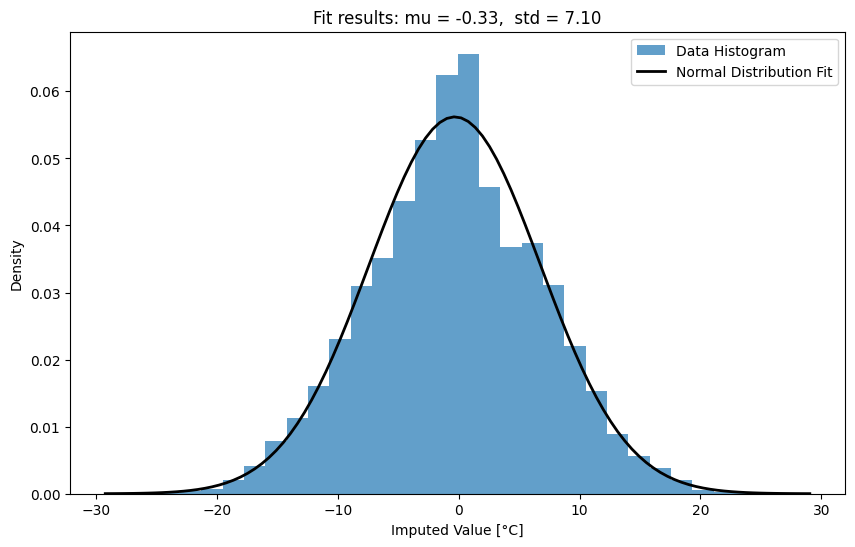

In [ ]:
from scipy.stats import norm

# mean og std af hitastigi
mean = df['Imputed Value [°C]'].mean()
std = df['Imputed Value [°C]'].std()

# figure stærð
plt.figure(figsize=(10, 6))

# Plot histogram af hitastigi
hist_data = plt.hist(df['Imputed Value [°C]'], bins=30, alpha=0.7, density=True, label='Data Histogram')

# punkta x-ás fyrir normal fall
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# Búa til normal gauss dreifingu
p = norm.pdf(x, mean, std)

# plota normal gauss dreifingu yfir histogram
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution Fit')

title = "Fit results: mu = %.2f,  std = %.2f" % (mean, std)
plt.title(title)
plt.xlabel('Imputed Value [°C]')
plt.ylabel('Density')
plt.legend()

plt.show()

Tölulegur reikningur hingað til hefur staðist vel og eftir að bera þær niðurstöður fram fyrir sérfræðing í Landsvirkjun voru þetta allt mjög trúlegar skekkjur og niðurstöður.

En samt sem áður vildum við nota einhverja aðra aðferð til að reyna bera niðurstöður saman við.

Samkvæmt athugasemd frá kennara hefur RNN tauganet reynst mjög gott þegar kemur að spá fyrir hitastigi og þar sem við höfum ekki nein yfirfarin gögn til að bera fyrri aðferð við vildum við hanna RNN tauganet og sjá hvort niðurstöður yrðu því sambærilegar tölulegum reikningi hér að ofan.

Því er hér fyrir neðan RNN taugakerfi sem ágiskar á hitastig í Setur_RH gagnasetti.

Epoch 1/20
6460/6460 [==============================] - 61s 9ms/step - loss: 0.0061 - val_loss: 0.0015
Epoch 2/20
6460/6460 [==============================] - 54s 8ms/step - loss: 0.0043 - val_loss: 0.0014
Epoch 3/20
6460/6460 [==============================] - 83s 13ms/step - loss: 0.0041 - val_loss: 0.0012
Epoch 4/20
6460/6460 [==============================] - 67s 10ms/step - loss: 0.0040 - val_loss: 0.0016
Epoch 5/20
6460/6460 [==============================] - 66s 10ms/step - loss: 0.0040 - val_loss: 0.0013
Epoch 6/20
8075/8075 [==============================] - 30s 4ms/step


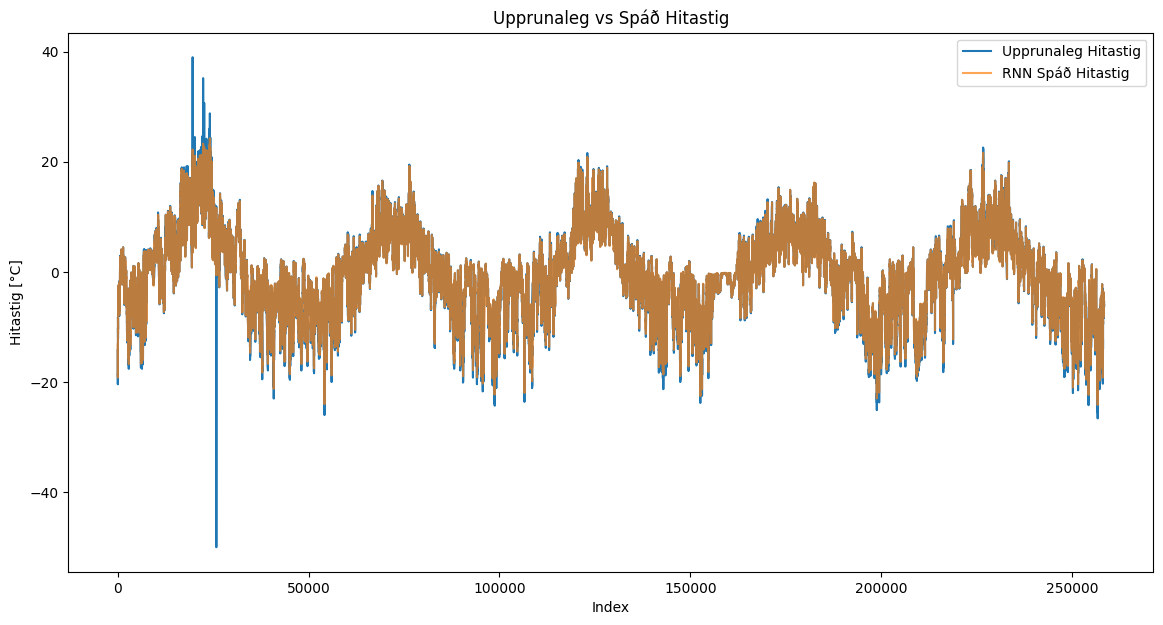

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.losses import Huber
import matplotlib.pyplot as plt

# Hlaða gögnin
df = pd.read_excel('Setur_RH.xlsx', skiprows=16)
#Breyta , í . svo python reiknar eitthvað og breytir missing values í NaN.
df['Value [°C]'] = pd.to_numeric(df['Value [°C]'].astype(str).str.replace(',', '.'), errors='coerce')

# Drop-a öllum missing values. aka '---'.
df.dropna(subset=['Value [°C]'], inplace=True)

# Svo það kemur ekki index error
df.reset_index(drop=True, inplace=True)

# Sér um extreme outliers. Þ.e. Ef gildi er yfir +- 50 þá breytist það í +-50
outlier_threshold_high = 50  # Má breyta eftir gagnasetti
outlier_threshold_low = -50  # Má breyta eftir gagnasetti
df['Value [°C]'] = df['Value [°C]'].clip(lower=outlier_threshold_low, upper=outlier_threshold_high)

# Normalize-a gögninn fyrir vinnslu
scaler = RobustScaler()
df['Value [°C]_scaled'] = scaler.fit_transform(df[['Value [°C]']])

# fall sem breytir gagnasett í röð fyrir LSTM úrvinnslu
def create_dataset(data, time_step=1):
    dataX, dataY = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(data[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Choose a time step
time_step = 10
# Reshape to [-1, 1] because we only have one feature
scaled_data = df['Value [°C]_scaled'].values.reshape(-1, 1)
# Create the sequence dataset
X, y = create_dataset(scaled_data, time_step)

# Reshape input to be [samples, time steps, features] for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# LSTM model
model = Sequential()
model.add(LSTM(40, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(30, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(30, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Þjappa saman módel með adam og Huber, Huber ekki jafn viðkvæmur og mse í outliers
model.compile(optimizer='adam', loss=Huber(delta=3.0))

# Bý til early callback, ef val_loss hættir að verða betra þá klára model fit svo
# við over fittum ekki.
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# fit-a módel
model.fit(X, y, epochs=20, validation_split=0.2, callbacks=[early_stop], batch_size=32)

# Predicting and inverse transforming the predictions
# Ágiskun af módel
predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)

# Plott-a niðurstöður og samanburð
actual_values = scaler.inverse_transform(y.reshape(-1, 1))

plt.figure(figsize=(14, 7))
plt.plot(actual_values, label="Upprunaleg Hitastig")
plt.plot(predictions, label="RNN Spáð Hitastig", alpha=0.7)
plt.title('Setur_RH: Upprunaleg vs Spáð Hitastig')
plt.xlabel('Index')
plt.ylabel('Hitastig [°C]')
plt.legend()
plt.show()


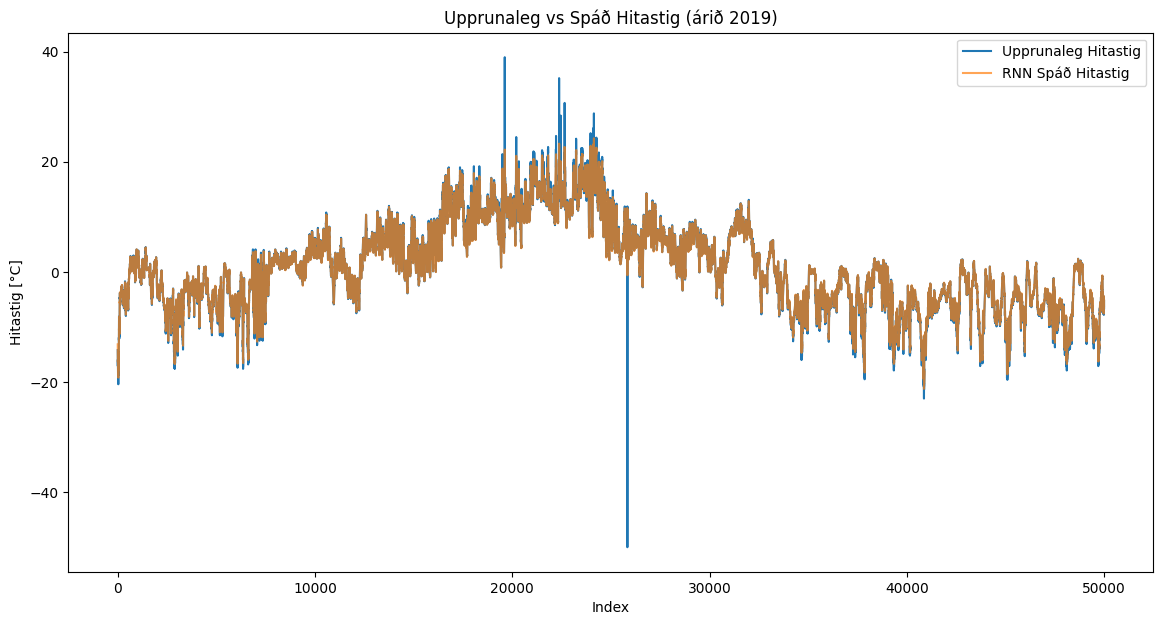

In [ ]:

plt.figure(figsize=(14, 7))
plt.plot(actual_values[:50000], label="Upprunaleg Hitastig")
plt.plot(predictions[:50000], label="RNN Spáð Hitastig", alpha=0.7)
plt.title('Setur_RH: Upprunaleg vs Spáð Hitastig (árið 2019)')
plt.xlabel('Index')
plt.ylabel('Hitastig [°C]')
plt.legend()
plt.show()


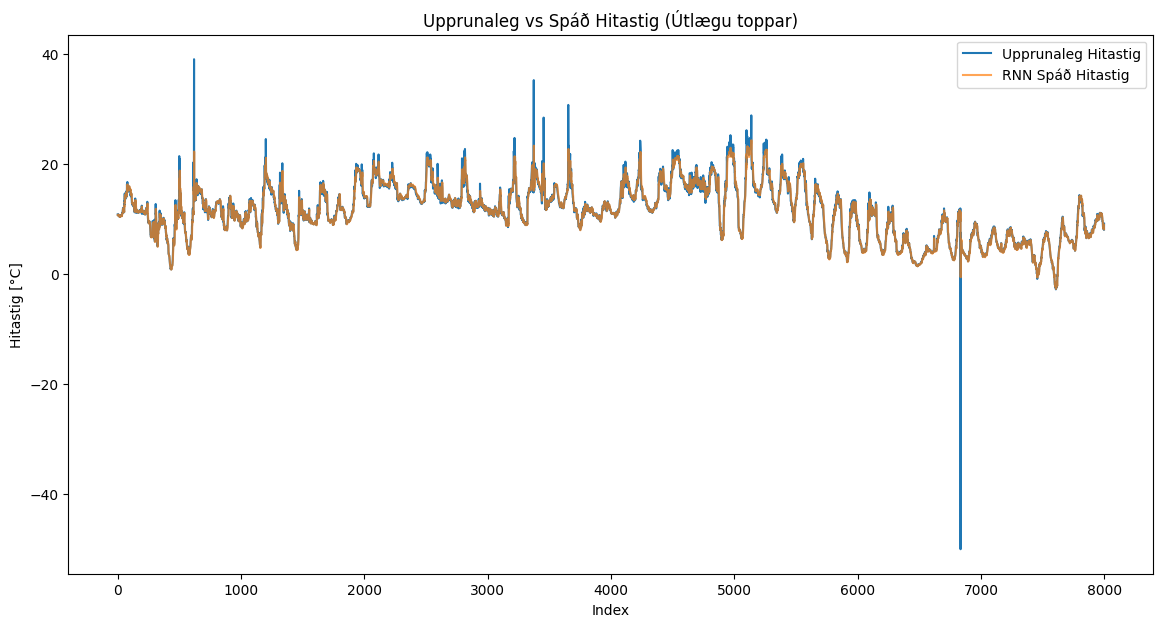

In [ ]:

plt.figure(figsize=(14, 7))
plt.plot(actual_values[19000:27000], label="Upprunaleg Hitastig")
plt.plot(predictions[19000:27000], label="RNN Spáð Hitastig", alpha=0.7)
plt.title('Setur_RH: Upprunaleg vs Spáð Hitastig (Útlægu toppar)')
plt.xlabel('Index')
plt.ylabel('Hitastig [°C]')
plt.legend()
plt.show()


Gildi í kringum stærsta útlæga topp

In [ ]:
min_index = np.argmin(actual_values)
print(np.unravel_index(min_index, actual_values.shape))

print(actual_values[25820:25841])
print(predictions[25820:25841])

(25835, 0)
[[  9.7]
 [  9.9]
 [ 11. ]
 [ 10.9]
 [ 11.5]
 [ 10.8]
 [ 11.2]
 [ 11.8]
 [ 10.4]
 [ 10.8]
 [ 10.1]
 [ 10.1]
 [  9.5]
 [ 11.9]
 [ 11.8]
 [-50. ]
 [  7.5]
 [  6.8]
 [  6.1]
 [  6.1]
 [  6. ]]
[[ 9.623885 ]
 [ 9.664094 ]
 [ 9.801201 ]
 [10.683993 ]
 [10.681112 ]
 [11.288218 ]
 [10.803466 ]
 [11.19867  ]
 [11.609631 ]
 [10.616794 ]
 [10.921069 ]
 [10.216493 ]
 [10.183958 ]
 [ 9.593739 ]
 [11.308728 ]
 [11.322591 ]
 [-0.5962775]
 [ 2.2791739]
 [ 5.9061356]
 [ 6.138057 ]
 [ 6.266611 ]]


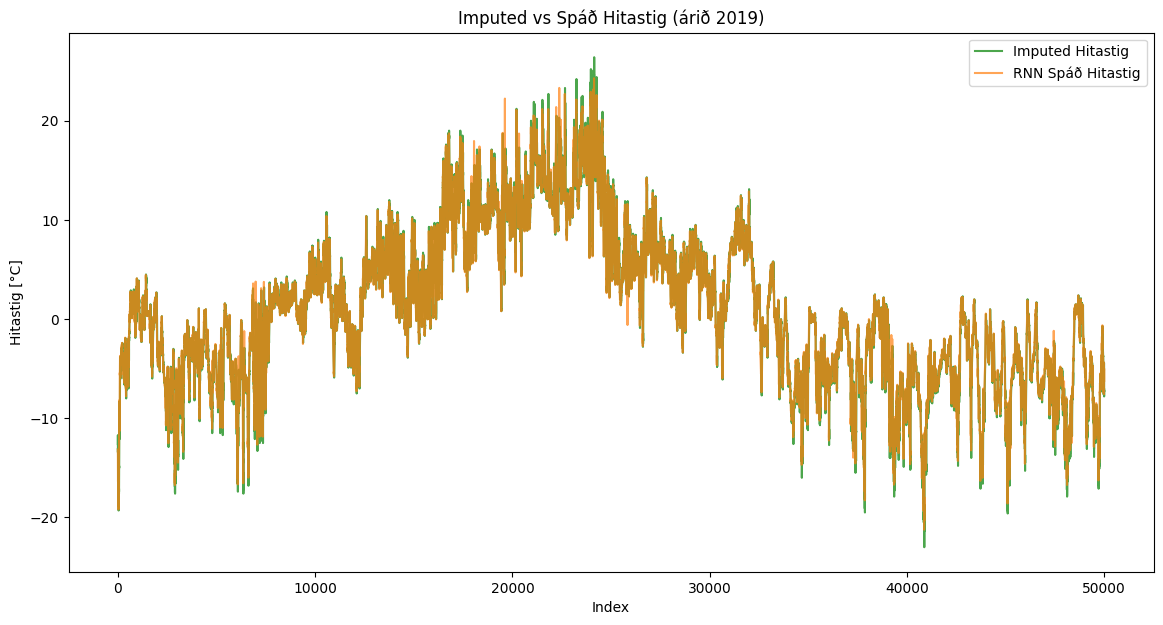

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df1['Imputed Value [°C]'][:50000], label='Imputed Hitastig', color='green', alpha=0.7)
plt.plot(predictions[:50000], label="RNN Spáð Hitastig", color='C1', alpha=0.7)
plt.title('Setur_RH: Imputed vs Spáð Hitastig (árið 2019)')
plt.xlabel('Index')
plt.ylabel('Hitastig [°C]')
plt.legend()
plt.show()

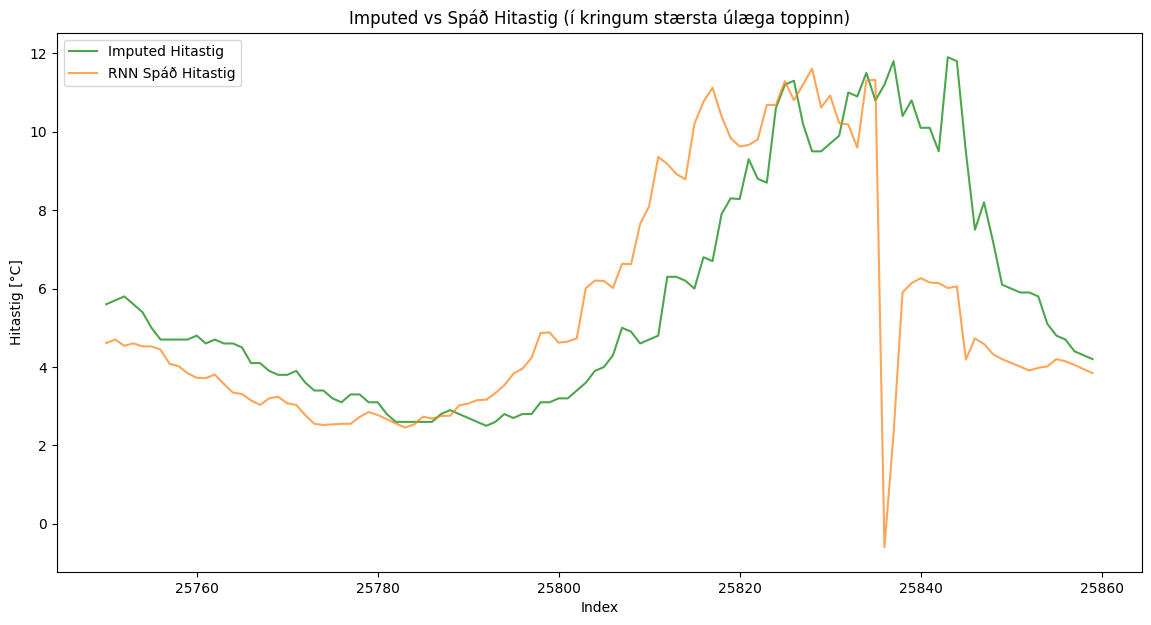

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df1.index[25750:25860] , df1['Imputed Value [°C]'][25750:25860], label='Imputed Hitastig', color='green', alpha=0.7)
plt.plot(df1.index[25750:25860] , predictions[25750:25860], label="RNN Spáð Hitastig", color='C1', alpha=0.7)
plt.title('Setur_RH: Imputed vs Spáð Hitastig (í kringum stærsta úlæga toppinn)')
plt.xlabel('Index')
plt.ylabel('Hitastig [°C]')
plt.legend()
plt.show()

#Auka efni:

SVR módel sem tók 19 mín að keyra bara 50 þúsund stökk. Myndi vera alltof lengi að keyra allt gagnasettið en áhugavert að sjá niðurstöður þar sem þær eru ekki all slæmar.

Mean Squared Error: 0.17773136026909897


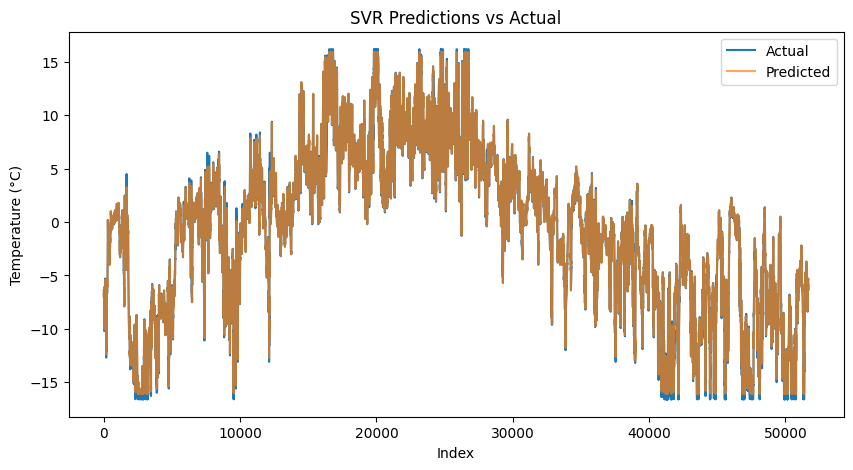

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Hlaða gögnum
df = pd.read_excel('Setur_RH.xlsx', skiprows=16)
df['Value [°C]'] = pd.to_numeric(df['Value [°C]'].astype(str).str.replace(',', '.'), errors='coerce')
df.dropna(inplace=True)  # Ensure no NA values
df.reset_index(drop=True, inplace=True)  # Reset index if any rows were dropped

# Díla við outliers
outlier_threshold_high = df['Value [°C]'].quantile(0.99)  # 99th percentile
outlier_threshold_low = df['Value [°C]'].quantile(0.01)   # 1st percentile
df['Value [°C]'] = np.clip(df['Value [°C]'], outlier_threshold_low, outlier_threshold_high)

# búa til lag í setti
time_step = 5  # Number of lags to use
for i in range(1, time_step + 1):
    df[f'lag_{i}'] = df['Value [°C]'].shift(i)

df.dropna(inplace=True)  # dropa NaN línur sem skapast í lag

# Skipta í X og y
X = df[[f'lag_{i}' for i in range(1, time_step + 1)]]
y = df['Value [°C]']

# Skipta í train og test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Skala gögn
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Þjálfa módel
model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
model.fit(X_train_scaled, y_train_scaled.ravel())

# Spá á test gögn
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Reikna MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.title('SVR Predictions vs Actual')
plt.xlabel('Index')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()
